<img src="https://www.kcha.org/portals/0/Images/Leader/Leader_91.jpg" style="height:500px" />

# King County Housing Data Analysis


***


**Author**: Andre Layton  
***

## Overview
Despite mortgage interest rates climbing to a record high in the last 35 years, the United States is continuing to see a seller's market, where there is a higher demand for purchasing a home than there are homes available to buy. Now, selling a home may sound daunting, but once the home is priced and listed for sale, you want to ensure you get the highest value possible. Increasing this potential value can be as easy as making minor aesthetic upgrades, such as painting the walls, or major changes, such as a complete kitchen remodel. This project aims to give sellers an idea of what renovations in particular will increase the sales price of the home, and to estimate how much those renovations impact the home's value. 

## Business Problem
A homeowner has a property in northwest Washington that they are looking to sell. However, they have no prior experience in real estate, and they want to be sure they are not missing out on a chance to maximize their return. They recognize that working with a real estate agent will help their profit potential, and making changes to the home prior to listing it will do the same. Therefore, the homeowner would like to know what potential renovations will increase the property value. I am analyzing housing data from King County, WA in order to identify what opportunities there are to increase the sales price of the home, and by how much. 
***

![King-County-Picture](images/KingCountyHousingPicture2.jpg)

## Data Understanding

The King County Housing dataset is a public dataset that provides an extensive list of homes with a wide range of features and characteristics (e.g. sales price, square footage (sq. ft.), year built, etc.). The dataset also contains metadata with a list and explanation of the aforementioned features. To begin, I load the dataset, drop a few of the unnecessary features we know we do not need, and preview a few of the records.  

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import AutoMinorLocator
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.feature_selection import RFE
import statsmodels.api as sm
import math

%matplotlib inline
plt.style.use('ggplot')

In [ ]:
# %load column_names.md
# Column Names and Descriptions for King County Data Set

* `id` - Unique identifier for a house
* `date` - Date house was sold
* `price` - Sale price (prediction target)
* `bedrooms` - Number of bedrooms
* `bathrooms` - Number of bathrooms
* `sqft_living` - Square footage of living space in the home
* `sqft_lot` - Square footage of the lot
* `floors` - Number of floors (levels) in house
* `waterfront` - Whether the house is on a waterfront
  * Includes Duwamish, Elliott Bay, Puget Sound, Lake Union, Ship Canal, Lake Washington, Lake Sammamish, other lake, and river/slough waterfronts
* `greenbelt` - Whether the house is adjacent to a green belt
* `nuisance` - Whether the house has traffic noise or other recorded nuisances
* `view` - Quality of view from house
  * Includes views of Mt. Rainier, Olympics, Cascades, Territorial, Seattle Skyline, Puget Sound, Lake Washington, Lake Sammamish, small lake / river / creek, and other
* `condition` - How good the overall condition of the house is. Related to maintenance of house.
  * See the [King County Assessor Website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) for further explanation of each condition code
* `grade` - Overall grade of the house. Related to the construction and design of the house.
  * See the [King County Assessor Website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) for further explanation of each building grade code
* `heat_source` - Heat source for the house
* `sewer_system` - Sewer system for the house
* `sqft_above` - Square footage of house apart from basement
* `sqft_basement` - Square footage of the basement
* `sqft_garage` - Square footage of garage space
* `sqft_patio` - Square footage of outdoor porch or deck space
* `yr_built` - Year when house was built
* `yr_renovated` - Year when house was renovated
* `address` - The street address
* `lat` - Latitude coordinate
* `long` - Longitude coordinate

Most fields were pulled from the [King County Assessor Data Download](https://info.kingcounty.gov/assessor/DataDownload/default.aspx).

The `address`, `lat`, and `long` fields have been retrieved using a third-party [geocoding API](https://docs.mapbox.com/api/search/geocoding/). In some cases due to missing or incorrectly-entered data from the King County Assessor, this API returned locations outside of King County, WA. If you plan to use the `address`, `lat`, or `long` fields in your modeling, consider identifying outliers prior to including the values in your model.


In [3]:
# Load the dataset
housing_data = pd.read_csv('kc_house_data.csv')
housing_df2 = housing_data.drop(['date', 'view', 'sqft_above', 'sqft_basement', 'yr_renovated', 'address', 'lat', 'long'], 
                               axis=1)
housing_df2.head(10)

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,condition,grade,heat_source,sewer_system,sqft_garage,sqft_patio,yr_built
0,7399300360,675000.0,4,1.0,1180,7140,1.0,NO,NO,NO,Good,7 Average,Gas,PUBLIC,0,40,1969
1,8910500230,920000.0,5,2.5,2770,6703,1.0,NO,NO,YES,Average,7 Average,Oil,PUBLIC,0,240,1950
2,1180000275,311000.0,6,2.0,2880,6156,1.0,NO,NO,NO,Average,7 Average,Gas,PUBLIC,0,0,1956
3,1604601802,775000.0,3,3.0,2160,1400,2.0,NO,NO,NO,Average,9 Better,Gas,PUBLIC,200,270,2010
4,8562780790,592500.0,2,2.0,1120,758,2.0,NO,NO,YES,Average,7 Average,Electricity,PUBLIC,550,30,2012
5,2807100156,625000.0,2,1.0,1190,5688,1.0,NO,NO,YES,Average,7 Average,Electricity,PUBLIC,300,0,1948
6,5122400111,1317227.0,3,3.0,2080,27574,1.0,NO,NO,NO,Good,9 Better,Oil,PRIVATE,0,150,1951
7,7137850210,820000.0,3,2.5,2214,3506,2.0,NO,NO,NO,Average,8 Good,Gas,PUBLIC,440,206,2019
8,2944500680,780000.0,4,2.5,2340,8125,2.0,NO,NO,NO,Average,8 Good,Gas,PUBLIC,440,70,1989
9,2619950340,975000.0,4,2.5,2980,5859,2.0,NO,NO,NO,Average,8 Good,Gas,PUBLIC,540,170,2011


For further insight, I explore some statistical information about the dataset, as well as a further look into the columns. 

In [4]:
housing_df2.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_garage,sqft_patio,yr_built
count,3.015500e+04,3.015500e+04,30155.000000,30155.000000,30155.000000,3.015500e+04,30155.000000,30155.000000,30155.000000,30155.000000
mean,4.538104e+09,1.108536e+06,3.413530,2.334737,2112.424739,1.672360e+04,1.543492,330.211142,217.412038,1975.163953
std,2.882587e+09,8.963857e+05,0.981612,0.889556,974.044318,6.038260e+04,0.567717,285.770536,245.302792,32.067362
min,1.000055e+06,2.736000e+04,0.000000,0.000000,3.000000,4.020000e+02,1.000000,0.000000,0.000000,1900.000000
25%,2.064175e+09,6.480000e+05,3.000000,2.000000,1420.000000,4.850000e+03,1.000000,0.000000,40.000000,1953.000000
50%,3.874011e+09,8.600000e+05,3.000000,2.500000,1920.000000,7.480000e+03,1.500000,400.000000,150.000000,1977.000000
75%,7.287100e+09,1.300000e+06,4.000000,3.000000,2619.500000,1.057900e+04,2.000000,510.000000,320.000000,2003.000000
max,9.904000e+09,3.075000e+07,13.000000,10.500000,15360.000000,3.253932e+06,4.000000,3580.000000,4370.000000,2022.000000


In [5]:
housing_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30155 entries, 0 to 30154
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            30155 non-null  int64  
 1   price         30155 non-null  float64
 2   bedrooms      30155 non-null  int64  
 3   bathrooms     30155 non-null  float64
 4   sqft_living   30155 non-null  int64  
 5   sqft_lot      30155 non-null  int64  
 6   floors        30155 non-null  float64
 7   waterfront    30155 non-null  object 
 8   greenbelt     30155 non-null  object 
 9   nuisance      30155 non-null  object 
 10  condition     30155 non-null  object 
 11  grade         30155 non-null  object 
 12  heat_source   30123 non-null  object 
 13  sewer_system  30141 non-null  object 
 14  sqft_garage   30155 non-null  int64  
 15  sqft_patio    30155 non-null  int64  
 16  yr_built      30155 non-null  int64  
dtypes: float64(3), int64(7), object(7)
memory usage: 3.9+ MB


### Understanding Sales Price:

Before I begin preparing my data for modeling and visualization, I want to take a deep look at the target variable, which in this case is the sales price. First, I plot both a histogram and a QQ plot of the sales price feature to understand the distribution of the data. 

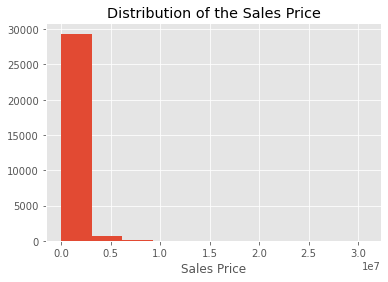

In [6]:
# Plot the distribution of the sales price column
housing_df2['price'].hist()
plt.xlabel('Sales Price')
plt.title('Distribution of the Sales Price');

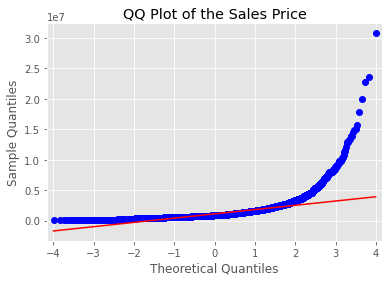

In [7]:
# Plot a QQ-plot
sm.qqplot(housing_df2['price'], line='r')
plt.title('QQ Plot of the Sales Price');

The plots above show that the price data is not normally distributed. In fact, the histogram exhibits right-skewness, and the QQ plot's data points fit close to the regression line within a certain quantile range. However, the QQ plot's data points are not linear, and suggests outliers that need to be addressed. 

I decide to drop these outliers to better prepare for data modeling, and first create a function to find these outliers using the interquartile range (IQR) method, before dropping the outliers from the dataset. 

In [8]:
# Create a function to find outliers using IQR
def find_outliers(df):
    q1 = df.quantile(.25)
    q3 = df.quantile(.75)
    IQR = q3 - q1
    outliers = df[((df < (q1 - 1.5*IQR)) | (df > (q3 + 1.5*IQR)))]
    return outliers

outliers_list = find_outliers(housing_df2['price'])
outliers_list

27       4500000.0
36       2450000.0
43       3850000.0
84       2500000.0
118      3000000.0
           ...    
30100    2588000.0
30106    2875000.0
30126    3754500.0
30130    2435000.0
30140    2650000.0
Name: price, Length: 1994, dtype: float64

In [9]:
Q1 = housing_df2['price'].quantile(.25)
Q3 = housing_df2['price'].quantile(.75)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

# Create arrays of Boolean values that identify outliers
upper_array = np.where(housing_df2['price'] > upper)[0]
lower_array = np.where(housing_df2['price'] < lower)[0]
 
# Remove the outliers
housing_df2.drop(index=upper_array, inplace=True)
housing_df2.drop(index=lower_array, inplace=True)

housing_df2.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_garage,sqft_patio,yr_built
count,2.816100e+04,2.816100e+04,28161.000000,28161.000000,28161.000000,2.816100e+04,28161.000000,28161.000000,28161.000000,28161.000000
mean,4.572098e+09,9.415585e+05,3.358084,2.247505,1987.851142,1.561351e+04,1.523739,314.413302,202.336245,1974.448422
std,2.881335e+09,4.348862e+05,0.954562,0.797944,799.542258,5.399179e+04,0.567227,272.278543,226.883908,31.907246
min,1.000055e+06,2.736000e+04,0.000000,0.000000,3.000000,4.020000e+02,1.000000,0.000000,0.000000,1900.000000
25%,2.125049e+09,6.300000e+05,3.000000,2.000000,1390.000000,4.731000e+03,1.000000,0.000000,40.000000,1953.000000
50%,3.881900e+09,8.299500e+05,3.000000,2.500000,1860.000000,7.320000e+03,1.500000,380.000000,140.000000,1977.000000
75%,7.300401e+09,1.199000e+06,4.000000,2.500000,2460.000000,1.013700e+04,2.000000,500.000000,300.000000,2002.000000
max,9.904000e+09,2.276500e+06,11.000000,7.500000,8020.000000,3.067495e+06,4.000000,3580.000000,4370.000000,2022.000000


The statistical breakdown above shows how the sales price column has changed with the outliers dropped, and the histogram below now exhibits a more normally distributed visualization. This helps ensure I am not violating any assumptions when modeling.

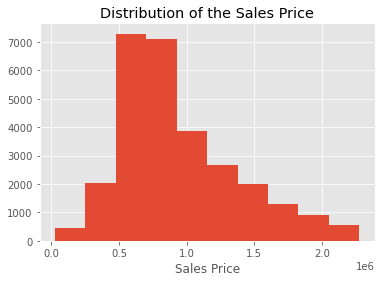

In [10]:
# Plot the distribution of the sales price column
housing_df2['price'].hist()
plt.xlabel('Sales Price')
plt.title('Distribution of the Sales Price');

## Data Preparation
### Data Cleaning:

To prepare a final dataset for modeling, I begin by keeping the features of interest to me, as well as remove the features I can not change such as the year the home was built or whether it is located on a waterfront. This will leave heat sources as the only categorical column in the dataset, and will warrant a further look into how the dataset is broken down based on the heat sources.

In [11]:
# Begin filtering data
housing_df3 = housing_df2[['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'heat_source',
                          'sqft_garage', 'sqft_patio']]
housing_df3.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,heat_source,sqft_garage,sqft_patio
0,7399300360,675000.0,4,1.0,1180,7140,1.0,Gas,0,40
1,8910500230,920000.0,5,2.5,2770,6703,1.0,Oil,0,240
2,1180000275,311000.0,6,2.0,2880,6156,1.0,Gas,0,0
3,1604601802,775000.0,3,3.0,2160,1400,2.0,Gas,200,270
4,8562780790,592500.0,2,2.0,1120,758,2.0,Electricity,550,30


I explore the different heat sources present in the dataset by listing out the counts of each.
> The data below shows the top three heat sources are gas, electricity, and oil, in descending order. 

In [12]:
housing_df3['heat_source'].value_counts()

Gas                  18893
Electricity           6260
Oil                   2822
Gas/Solar               76
Electricity/Solar       57
Other                   18
Oil/Solar                4
Name: heat_source, dtype: int64

In order to refine the dataset further, I will focus the scope to just the top three heat sources since that is where a majority of the data lies. I will also "dummy" the heat source column, for easier statistical analysis, and clean up the column names.

In [13]:
# Filter dataset to houses with certain heating sources (e.g., the top three)
top3_hs = ['Gas', 'Electricity', 'Oil']
housing_df3 = housing_df3[housing_df3['heat_source'].isin(top3_hs)]
housing_df3.tail()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,heat_source,sqft_garage,sqft_patio
30150,7834800180,1555000.0,5,2.0,1910,4000,1.5,Oil,0,210
30151,194000695,1313000.0,3,2.0,2020,5800,2.0,Gas,0,520
30152,7960100080,800000.0,3,2.0,1620,3600,1.0,Gas,240,110
30153,2781280080,775000.0,3,2.5,2570,2889,2.0,Gas,480,100
30154,9557800100,500000.0,3,1.5,1200,11058,1.0,Oil,420,0


In [14]:
# Dummying the 'heat_source' column
housing_df4 = pd.get_dummies(housing_df3, prefix=['Heat Source'], prefix_sep=': ', columns = ['heat_source'])

# Rename features
housing_df4.rename(columns= {'id':'House ID Number', 'price':'Sales Price', 'bedrooms':'No. of Bedrooms', 
                             'bathrooms':'No. of Bathrooms', 'sqft_living':'Sq. Ft. (Living Space)', 'sqft_lot':'Sq. Ft. (Lot)',
                             'floors':'No. of Floors', 'sqft_garage':'Sq. Ft. (Garage)', 'sqft_patio':'Sq. Ft. (Patio)'}, 
                   inplace=True)

# Reorder columns & set new index
floors_col = housing_df4.pop('No. of Floors')
housing_df4.insert(4, floors_col.name, floors_col)
housing_df4.set_index('House ID Number').head()

,Sales Price,No. of Bedrooms,No. of Bathrooms,No. of Floors,Sq. Ft. (Living Space),Sq. Ft. (Lot),Sq. Ft. (Garage),Sq. Ft. (Patio),Heat Source: Electricity,Heat Source: Gas,Heat Source: Oil
House ID Number,,,,,,,,,,,
7399300360,675000.0,4,1.0,1.0,1180,7140,0,40,0,1,0
8910500230,920000.0,5,2.5,1.0,2770,6703,0,240,0,0,1
1180000275,311000.0,6,2.0,1.0,2880,6156,0,0,0,1,0
1604601802,775000.0,3,3.0,2.0,2160,1400,200,270,0,1,0
8562780790,592500.0,2,2.0,2.0,1120,758,550,30,1,0,0


### Feature Selection:

Next, I create a correlation table and a heat-map to compare how each feature correlates with one another, both displaying the Pearson correlation coefficients.

In [15]:
housing_df4.corr()

,House ID Number,Sales Price,No. of Bedrooms,No. of Bathrooms,No. of Floors,Sq. Ft. (Living Space),Sq. Ft. (Lot),Sq. Ft. (Garage),Sq. Ft. (Patio),Heat Source: Electricity,Heat Source: Gas,Heat Source: Oil
House ID Number,1.000000,0.001814,0.003434,0.008790,0.042603,-0.002425,-0.120422,0.005129,-0.035008,-0.063644,0.071086,-0.022448
Sales Price,0.001814,1.000000,0.315638,0.432814,0.197222,0.564030,0.077719,0.238273,0.245476,-0.154912,0.183332,-0.070663
No. of Bedrooms,0.003434,0.315638,1.000000,0.557323,0.117191,0.645409,0.002803,0.295881,0.137686,-0.187112,0.218732,-0.081142
No. of Bathrooms,0.008790,0.432814,0.557323,1.000000,0.397364,0.721982,0.024248,0.422299,0.264242,-0.113026,0.267212,-0.259042
No. of Floors,0.042603,0.197222,0.117191,0.397364,1.000000,0.286241,-0.042310,0.111338,0.111554,0.032334,0.111435,-0.218002
Sq. Ft. (Living Space),-0.002425,0.564030,0.645409,0.721982,0.286241,1.000000,0.117642,0.481417,0.331139,-0.214017,0.276598,-0.133878
Sq. Ft. (Lot),-0.120422,0.077719,0.002803,0.024248,-0.042310,0.117642,1.000000,0.081111,0.160782,0.075292,-0.078875,0.018440
Sq. Ft. (Garage),0.005129,0.238273,0.295881,0.422299,0.111338,0.481417,0.081111,1.000000,0.172700,-0.196962,0.300939,-0.195324
Sq. Ft. (Patio),-0.035008,0.245476,0.137686,0.264242,0.111554,0.331139,0.160782,0.172700,1.000000,0.053209,0.012450,-0.092992
Heat Source: Electricity,-0.063644,-0.154912,-0.187112,-0.113026,0.032334,-0.214017,0.075292,-0.196962,0.053209,1.000000,-0.774403,-0.179842


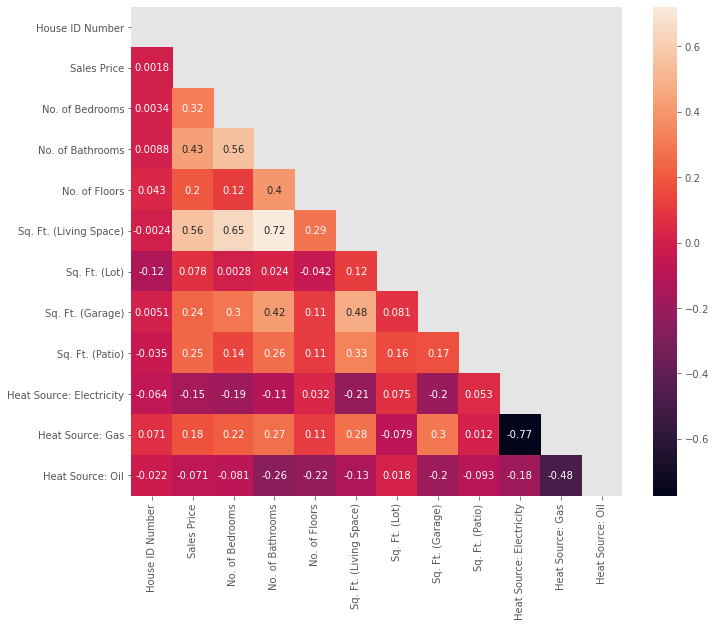

In [16]:
# Plot a heatmap with the Pearson coefficient values listed
fig, ax = plt.subplots(figsize=(11, 9))
mask = np.triu(np.ones_like(housing_df4.corr(), dtype=bool))
sns.heatmap(housing_df4.corr(), mask=mask, annot=True);

According to the heatmap above, the square footage of the living space and the number of bathrooms are two features that are highly correlated with the sales price of a home. Although, the visual shows that these two predictors are also highly correlated with each other, which suggests there could be a multicollinearity issue. However, the heat sources, when compared to the sales price, had low correlation values, with two - electricity and oil - exhibiting negative relationships. 

To prevent multicollinearity, it is key to identify which predictors are highly correlated among each other. 

In [17]:
# Create a dataframe with each pair of predictors and their correlation values
data_copy = housing_df4.copy()
data_copy = data_copy.corr().abs().stack().reset_index().sort_values(0, ascending=False)
data_copy['Predictor pairs'] = list(zip(data_copy['level_0'], data_copy['level_1']))
data_copy.set_index(['Predictor pairs'], inplace = True)
data_copy.drop(columns=['level_0', 'level_1'], inplace=True)
data_copy.rename(columns={0:'Correlation (r)'}, inplace=True)
data_copy.drop_duplicates(inplace=True)

In [18]:
data_copy.head(20)

,Correlation (r)
Predictor pairs,
"(House ID Number, House ID Number)",1.000000
"(Heat Source: Gas, Heat Source: Electricity)",0.774403
"(Sq. Ft. (Living Space), No. of Bathrooms)",0.721982
"(Sq. Ft. (Living Space), No. of Bedrooms)",0.645409
"(Sales Price, Sq. Ft. (Living Space))",0.564030
"(No. of Bedrooms, No. of Bathrooms)",0.557323
"(Heat Source: Gas, Heat Source: Oil)",0.483107
"(Sq. Ft. (Garage), Sq. Ft. (Living Space))",0.481417
"(No. of Bathrooms, Sales Price)",0.432814


Besides the first pair, there is a handful of pairs that exihibit high correlation - yielding correlation values over 0.50. Square footage of the living space is present in more than half of these pairs, specifically with the number of bathrooms and the number of bedrooms, but also with sales price, which is of interest to us. Choosing the square footage of the living space as one of our final predictors subsequently eliminates the number of bathrooms and bedrooms from the modeling process to prevent multicollinearity, despite the high correlation they both exhibit with sales price. 

I notice that a few of the heat sources are also present in the pairs with high correlation values (specifically, gas with both electricity and oil). This warrants a further look into whether heat sources might be a feature worth researching. I utilize the recursive feature elimination (RFE) method to determine if any of the heat sources are suitable for analysis. 

In [19]:
# Use RFE to aid in feature selection
lr_rfe = LinearRegression()
select = RFE(lr_rfe, n_features_to_select=3)

df5_copy = housing_df4.drop('Sales Price', axis=1)
y = housing_df4['Sales Price']
select.fit(X = df5_copy, y=y)
select.support_

array([False,  True,  True, False, False, False, False, False,  True,
       False, False])

Ironically, the results above indicate that electric power, as well as the number of bedrooms and the number of bathrooms, are the strongest features in relation to sales price. Although the latter two were eliminated prior due to their high correlation with the size of the living space, electric power being the third that the recursive elimination method selected encourages a further look into the heating sources.

The remainder of the analysis will focus on modeling the square footage of the living space and the heating sources with sales price, in order to explore their impact (or lack thereof). 

## Data Modeling
### Square Footage (Living Space) vs. Sales Price:
To begin the modeling portion of the analysis, let's visualize how the square footage of the living space compares against sales price. 

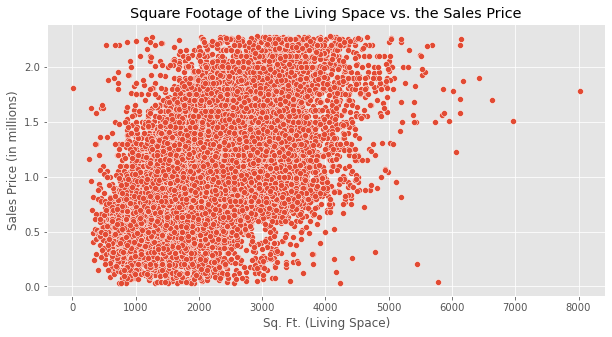

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))

# Y-axis formatter - Customizing the Y-axis scale
def million_formatter(x, pos):
    return str(round(x / 1e6, 1))
ax.yaxis.set_major_formatter(million_formatter)
ax.set_yticks(range(0, 3000000, 500000))

# Plot the data
sns.scatterplot(data = housing_df4, x='Sq. Ft. (Living Space)', y='Sales Price')
ax.set_xlabel("Sq. Ft. (Living Space)")
ax.set_ylabel("Sales Price (in millions)")
ax.set_title("Square Footage of the Living Space vs. the Sales Price");

The above plot shows that these two parameters could exhibit a semblance of a linear relationship, which requires a further look. I fit my data for modeling and print the regression results summary, in addition to the p-values to check for statistical significance. 

In [21]:
df4_copy = housing_df4.copy()
X = df4_copy[['Sq. Ft. (Living Space)']]
y = df4_copy['Sales Price']

# Model the regression and print the results
sqft_lr_model = sm.OLS(y, sm.add_constant(X)).fit()
sqft_lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Sales Price   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                 1.305e+04
Date:                Mon, 23 Oct 2023   Prob (F-statistic):               0.00
Time:                        00:08:08   Log-Likelihood:            -3.9747e+05
No. Observations:               27975   AIC:                         7.950e+05
Df Residuals:                   27973   BIC:                         7.950e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   3.316e+05   5750.530     57.660      0.000     3.2e+05    3.43e+05
Sq. Ft. (Living Space)   306.6441      2.684    114.241      0.000     301.383     311.905
==============================================================================
Omnibus:                     1491.764   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1891.903
Skew:                           0.533   Prob(JB):                         0.00
Kurtosis:                       3.697   Cond. No.                     5.75e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.75e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [22]:
sqft_lr_model.pvalues

const                     0.0
Sq. Ft. (Living Space)    0.0
dtype: float64

The results above tell us quite a bit. First, the R-squared value is .318, which is high enough to suggest the model sufficiently explains the relationship between the two parameters. Secondly, the p-values are less than .05, which also implies the predictors are statistically significant. As such, the model suggests there is a strong relationship between the square footage of the living space and the sales price of the home. Specifically, if we increase the square footage of the home's living space by one square foot, we estimate an approximate, associated change of \\$306.64 in the property's sales price. 

Below, I replot the dataset with the addition of a regression line to better exhibit the relationship between the two variables. I also plot the residuals in sales price to better see the distribution in the errors, and to use as an assessment of the regression model.

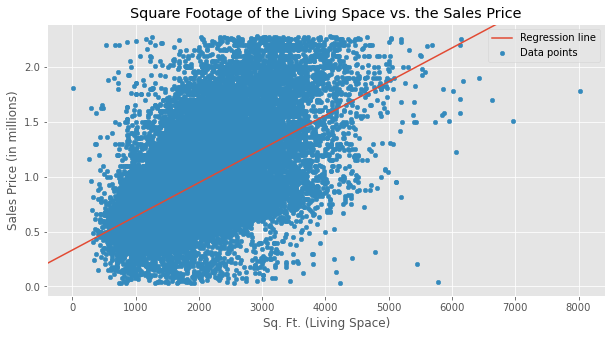

In [23]:
# plot the linear regression model 
fig, ax = plt.subplots(figsize=(10, 5))
ax.yaxis.set_major_formatter(million_formatter)
df4_copy.plot.scatter(x="Sq. Ft. (Living Space)", y="Sales Price", label="Data points", ax=ax)
sm.graphics.abline_plot(model_results=sqft_lr_model, label="Regression line", ax=ax)
ax.set_ylabel("Sales Price (in millions)")
ax.set_title("Square Footage of the Living Space vs. the Sales Price")
ax.legend();

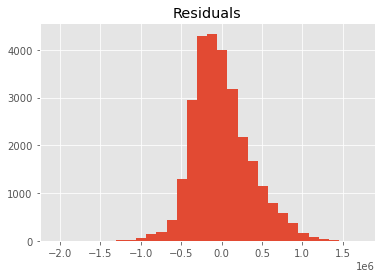

In [24]:
# Plot the residuals 
lr = LinearRegression().fit(X, y)
df4_copy['Calculated'] = lr.predict(X)
df4_copy['Residuals'] = y - df4_copy['Calculated']
fig, ax = plt.subplots()
ax.hist(df4_copy['Residuals'], bins=30)
ax.set_title("Residuals");

As shown above, the first plot displays the same scatterplot with a best-of-fit regression line that best reflects the relationship mentioned earlier. Note the line's intercept, which matches with the model's deduction of $330,600. The line also suggests a strong linear relationship, which is what to expect considering the high correlation values derived earlier. This model could also serve as a baseline model to compare further and future models to. 

It is also crucial to point out the residuals plot, which is a semblance of a normal distribution, and further suggests that no assumptions are violated. This is key in the credibility of the model's results. 

### A Home's Heat Sources vs. Sales Price:
Next is a look at the heating sources and their impact on the property's sales price. To get a sense of how the data is distributed, I start by plotting the median sales price of the homes grouped by their respective heating sources.

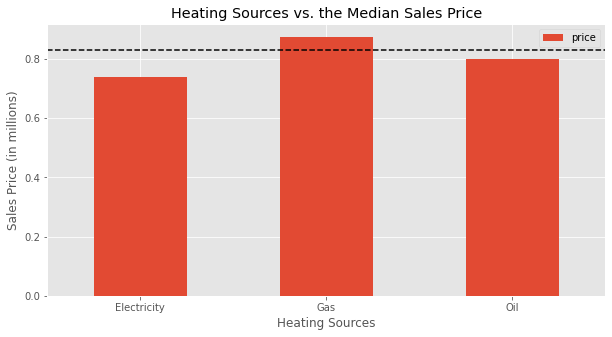

In [25]:
# Plot the heat sources and their median sales price
fig, ax = plt.subplots(figsize=(10, 5))

ax.ticklabel_format(style='plain', axis='both')
ax.yaxis.set_major_formatter(million_formatter)
housing_df3.groupby('heat_source').median().plot.bar(y="price", ax=ax).set(
    ylabel = "Sales Price (in millions)", xlabel="Heating Sources", title="Heating Sources vs. the Median Sales Price")
ax.tick_params(axis='x', labelrotation=0)
ax.axhline(y=housing_df3['price'].median(), label="median", color="black", linestyle="--");

This tells me quite a bit. First, that the median gas-powered home is approximately \\$900,000, while the median electric-powered home sells for a little over \\$700,000. In addition, despite having the lowest record count among the three heating sources, oil-powered homes seem to be priced higher, on median, than electric-powered homes. This visual suggests that the electric-powered homes are much cheaper than both the oil and gas-powered properties, in the dataset. Unfortunately, this plot communicates nothing about whether I can use, or even trust, these heating sources to influence sales price. I will model all three heating sources with the sales price to uncover any relationship. 

In order for the feature to be modeled, I will use pandas to "dummy" out the column, and use one hot encoding to transform the categorical data into a numerical nature. 

In [26]:
# Create a copy of the dataset and print the regression results for the heating sources only
heating_df4 = pd.get_dummies(housing_df3, prefix=['Heat Source'], prefix_sep=': ', columns = ['heat_source'], drop_first=True)
heating_df4.rename(columns= {'id':'House ID Number', 'price':'Sales Price', 'bedrooms':'No. of Bedrooms', 
                             'bathrooms':'No. of Bathrooms', 'sqft_living':'Sq. Ft. (Living Space)', 'sqft_lot':'Sq. Ft. (Lot)',
                             'floors':'No. of Floors', 'sqft_garage':'Sq. Ft. (Garage)', 'sqft_patio':'Sq. Ft. (Patio)'}, 
                   inplace=True)

X_heating = heating_df4[['Heat Source: Gas', 'Heat Source: Oil']]
heating_model = sm.OLS(y, sm.add_constant(X_heating))
heating_results = heating_model.fit()

heating_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Sales Price   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     492.7
Date:                Mon, 23 Oct 2023   Prob (F-statistic):          5.11e-211
Time:                        00:08:33   Log-Likelihood:            -4.0235e+05
No. Observations:               27975   AIC:                         8.047e+05
Df Residuals:                   27972   BIC:                         8.047e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              8.16e+05   5390.962    151.367      0.000    8.05e+05    8.27e+05
Heat Source: Gas  1.804e+05   6220.291     28.996      0.000    1.68e+05    1.93e+05
Heat Source: Oil  3.366e+04   9671.159      3.480      0.001    1.47e+04    5.26e+04
==============================================================================
Omnibus:                     2679.443   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3510.387
Skew:                           0.853   Prob(JB):                         0.00
Kurtosis:                       3.313   Cond. No.                         5.37
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The first thing we notice in the model summary is the adjusted R-squared score, which is 0.034. The heating sources have been able to explain just a little over 3% of the variance in the sales price of these homes. This value is small enough that we can safely say the relationship between the heat sources and sales price of a home is weak. Also, take notice of the F-statistic and it's p-value, which is well below zero - indicating that, despite the low adjusted R-squared score, even this regression model has been able to fit the data better than the mean model (which is basically a flat horizontal line passing through the mean value of price).

Note that the regression model's intercept, or constant value, will represent the estimated mean sales price for electric-powered homes, due to that feature being dropped in the dummying process. The estimate, \\$816,000, is statistically significant with a p-value less than our alpha of 0.05, and has a 95% confidence interval between \\$805,000 and \\$827,000. Both Gas & Oil features also have p-values less than 0.05, confirming their coefficients to be statistically significant. Because electric-powered homes have become the reference category, the coefficients for both Gas & Oil features express the differences associated with those home features vs. electric-powered homes. In other words, for example, compared to electric-powered homes, the model estimates the sales price will see an associated increase of about \\$180,400 for gas-powered homes, and approximately \\$33,660 for oil. Now, due to the low adjusted R-squared score, the credibility behind these interpretations is low, as well.

### Multiple Linear Regression:
After exploring the selected features individually, this analysis will analyze them both together in the hopes of improving the model and interpreting those changes. I fit the model to include only the features examined to this point and print a summary of the regression results.

In [27]:
# Create a model with multiple predictors
multi_regX = housing_df4[['Sq. Ft. (Living Space)', 'Heat Source: Electricity', 'Heat Source: Gas', 'Heat Source: Oil']]

multi_regmodel = sm.OLS(y, sm.add_constant(multi_regX))
multi_reg_results = multi_regmodel.fit()
multi_reg_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Sales Price   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     4375.
Date:                Mon, 23 Oct 2023   Prob (F-statistic):               0.00
Time:                        00:08:40   Log-Likelihood:            -3.9745e+05
No. Observations:               27975   AIC:                         7.949e+05
Df Residuals:                   27971   BIC:                         7.949e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     2.515e+05   4377.453     57.450      0.000    2.43e+05     2.6e+05
Sq. Ft. (Living Space)     302.1985      2.791    108.286      0.000     296.729     307.669
Heat Source: Electricity  5.987e+04   3934.834     15.215      0.000    5.22e+04    6.76e+04
Heat Source: Gas          9.783e+04   3545.019     27.596      0.000    9.09e+04    1.05e+05
Heat Source: Oil          9.379e+04   5287.080     17.739      0.000    8.34e+04    1.04e+05
==============================================================================
Omnibus:                     1454.825   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1836.864
Skew:                           0.526   Prob(JB):                         0.00
Kurtosis:                       3.686   Cond. No.                     4.95e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.23e-23. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

The results above, when compared to the earlier individual regression analyses, also conveys quite a bit. First, the adjusted R-squared score (.319) is only slightly higher than the statistic determined in the analysis of the living space's square footage (.318), which I mentioned could also serve as the baseline model. This model, in other words, explains almost 32% of the variance in the sales price, but nothing more than the baseline model did. The coefficients have also changed, now that all the features are accounted for. The p-values for all these coefficients are below 0.05, implying their values are statistically significant. These can be seen below. 

In [28]:
multi_reg_results.pvalues

const                        0.000000e+00
Sq. Ft. (Living Space)       0.000000e+00
Heat Source: Electricity     4.520829e-52
Heat Source: Gas            2.062460e-165
Heat Source: Oil             5.042944e-70
dtype: float64

Below are the partial regression plots for all the model features. 

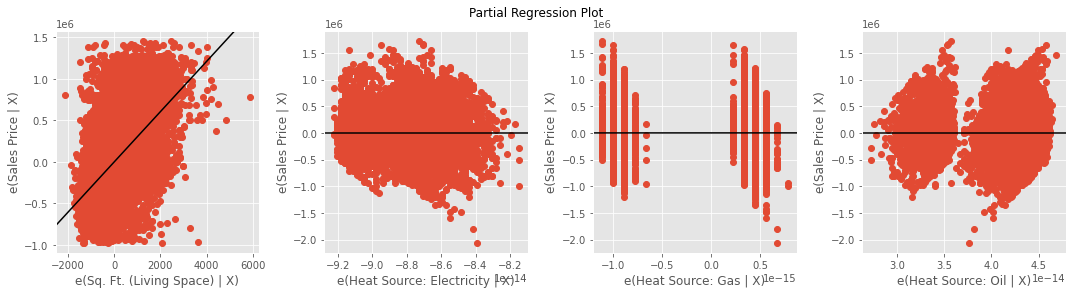

In [29]:
# Plot the partial regression plots for all the model features
fig = plt.figure(figsize=(15,15))
sm.graphics.plot_partregress_grid(
    multi_reg_results,
    exog_idx=list(multi_regX.columns),
    grid=(4,4),
    fig=fig)
plt.tight_layout()
plt.show()

I also plot the coefficients of the heating sources to point out the size of the associated change for each feature. In other words, the plot below suggests that gas-powered homes could see an associated increase of approximately \\$97,000 when compared to electric-powered homes, and about \\$93,000 for oil-powered homes via the same comparison. However, electric-powered homes are estimated to affect the sales price by almost \\$60,000; and although I did not plot the coefficient for the living space's square footage, the price of the home increases by roughly \\$302 for every square foot we add to the living space of the home. 

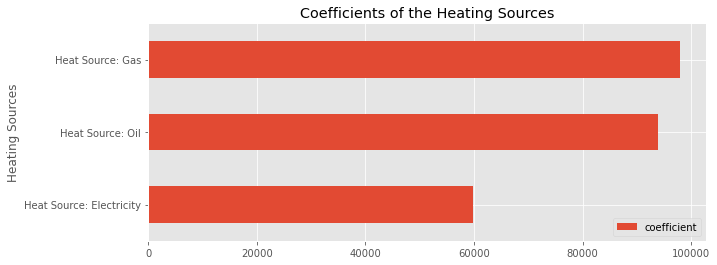

In [30]:
results_df = pd.concat([multi_reg_results.params, multi_reg_results.pvalues], axis=1)
results_df.columns = ["coefficient", "p-value"]

results_df = results_df[results_df["p-value"] < 0.05].sort_values(by="coefficient")

results_df.drop(["const", "Sq. Ft. (Living Space)"]).plot.barh(y="coefficient", title='Coefficients of the Heating Sources',
                                                              xlabel='Heating Sources', figsize=(10, 4));

In order to effectively assess how accurate our model is, the mean absolute error will give an idea of the average error. I calculate the residuals, take their absolute values, and divide the sum by the number of observations. 

In [31]:
multi_reg_results.resid.sum() / len(y)

-4.533601723364999e-09

In [32]:
multi_reg_results.resid

0        -30908.481156
1       -262366.113092
2       -908645.989560
3       -227063.044824
4        -57319.137790
             ...      
30150    632524.626454
30151    353244.749986
30152    -38875.836272
30153   -350964.443910
30154   -207914.414154
Length: 27975, dtype: float64

In [33]:
mae = multi_reg_results.resid.abs().sum() / len(y)
mae

279238.721620099

The mean absolute error is \\$279,239, which is how much our model is off by in any given prediction. This is quite high considering that our sales price prediction could be off by almost $300,000! Obviously, there is room for improvement in order to gain a more accurate model. 

## Conclusions
This analysis leads to the following conclusions:
1. Before listing the home, increase the living space of the home. Each square foot that gets added to the living space is projected to increase the price of the home by approximately \\$302. Increasing the square footage of the living space is confirmed to have the greatest impact to the sales price of the home, but is collinear with many other features and must, therefore, be modeled with a few select predictors.

2. If the home is electric-powered, and there is definite interest in changing the heating system of the property, I recommend renovating to a gas-powered home. Firstly, the median gas-powered home is priced much higher than the median electric and oil- powered home. As compared to electric power,  gas-powered homes are estimated to see an increase in price, on average, by \\$97,000, which is the highest among the heating sources present in the model. However, under normal circumstances, I would not recommend remodeling the heating system. The model suggests that the heating sources actually have a weak influence on a property's value, and inspires little confidence or credibility. 


## Limitations & Next Steps
This project is limited in a few ways, the first being it only takes into account housing data within the upper and lower bounds of the dataset. In addition, the features that correlated best with the sales price also exhibited strong relationships with one another. This limited the amount of features we could include and analyze, and warrant further, individual looks to observe any possible improvements to our model.

Further analyses could yield additional insights to which features and/or renovations are best to impact the sales price of the homes in the Pacific Northwest region. One such improvement is including location into the project to see the impact area has on price. Also, include more features to explore other predictors that may correlate better with the sales price of the home. 